In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_columns', None)

In [115]:
df = pd.read_csv('data/dataset_workout.csv')
df.head(3)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Calories,sugar_g,serving_size_g,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,sodium_g,cholesterol_g,Carbs,Proteins,Fats,meal_name,BMR,PAL,TDEE,cluster_id,E_raw,E_eff,E,pct_HRR,I,workload,S,Duration_min,D,pen_age,pen_bmi,pen_hrr,pen_skill,R
0,35,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,1.50,4,2,24.87,3,1806.0,31.77,120.47,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,3,Legs,Lats,Dumbbell flyes,1.72994,0.28505,267.68,106.05,71.63,Grilled Vegan Lunch,1495.20,1.900,2840.88000,2,0.295123,0.845312,0.570217,0.741237,0.526466,105,0.250000,60.0,0.333333,0.404762,0.335952,0.0,1,0.637310
1,23,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,1.90,4,2,23.48,3,1577.0,12.34,109.15,1.92,Bear Crawls,4,16,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,2,Chest,Lats,Lateral raises,0.69308,0.30061,214.32,85.41,56.97,Fried Vegetarian Lunch,1256.85,1.900,2388.01500,2,0.579037,0.902949,0.740993,0.551247,0.256055,64,0.225000,82.2,0.575163,0.119048,0.299555,0.0,0,0.862514
2,33,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,1.88,3,1,21.15,2,1608.0,42.81,399.43,4.70,Dips,5,22,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,2,Arms,Grip Strength,Standing calf raises,2.14248,0.21542,246.04,98.11,65.48,Boiled Paleo Breakfast,1307.55,1.725,2255.52375,1,0.186606,0.912713,0.549660,0.574534,0.289199,110,0.416667,54.6,0.274510,0.357143,0.238544,0.0,1,0.685580


In [116]:
user = pd.read_csv('data/new_user.csv')
user

,Age,Gender,Weight (kg),Height (m),BMI,Workout_Frequency (days/week),Daily meals frequency,diet_type,Experience_Level,Goal,WeightChange (kg),GoalDays,BMR,PAL,TDEE,CalorieChange,CaloriesToBurnTraining,CaloriesReducedFromFood,CaloriesPerDay,TotalWorkouts,CaloriesPerWorkout,cluster_id
0,22,Male,88.0,1.8,27.160494,2,2,Keto,2,Maintain,2.0,20,1900.0,1.55,2945.0,15400.0,7700.0,7700.0,2945.0,5.714286,1347.5,0


### Training dataset preparation

In [117]:
df.columns

Index(['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
       'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Workout_Type', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI',
       'Daily meals frequency', 'Calories', 'sugar_g', 'serving_size_g',
       'rating', 'Name of Exercise', 'Sets', 'Reps', 'Benefit',
       'Burns Calories (per 30 min)', 'Target Muscle Group',
       'Equipment Needed', 'Difficulty Level', 'Body Part', 'Type of Muscle',
       'Workout', 'sodium_g', 'cholesterol_g', 'Carbs', 'Proteins', 'Fats',
       'meal_name', 'BMR', 'PAL', 'TDEE', 'cluster_id', 'E_raw', 'E_eff', 'E',
       'pct_HRR', 'I', 'workload', 'S', 'Duration_min', 'D', 'pen_age',
       'pen_bmi', 'pen_hrr', 'pen_skill', 'R'],
      dtype='object')

In [118]:
numerical_features = ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 
                      'Workout_Frequency (days/week)', 'Daily meals frequency', 'Sets', 'Reps', 'Calories_Burned']

categorical_features = ['Gender', 'Experience_Level', 'cluster_id', 'Name of Exercise',
                        'Workout_Type', 'Target Muscle Group', 'Body Part', 
                        'Type of Muscle', 'Difficulty Level', 'Workout', 'Benefit']

In [119]:
selected_features = numerical_features + categorical_features
df_cleaned = df[selected_features].copy()
df_cleaned.head(3)

,Age,Weight (kg),Height (m),BMI,Workout_Frequency (days/week),Daily meals frequency,Sets,Reps,Calories_Burned,Gender,Experience_Level,cluster_id,Name of Exercise,Workout_Type,Target Muscle Group,Body Part,Type of Muscle,Difficulty Level,Workout,Benefit
0,35,65.27,1.62,24.87,4,3,5,21,1080.90,Male,2,2,Decline Push-ups,Strength,"Shoulders, Triceps",Legs,Lats,3,Dumbbell flyes,Improves shoulder health and posture
1,23,56.41,1.55,23.48,4,3,4,16,1809.91,Female,2,2,Bear Crawls,HIIT,"Back, Core, Shoulders",Chest,Lats,2,Lateral raises,Strengthens lower abs
2,33,58.98,1.67,21.15,3,2,5,22,802.26,Female,1,1,Dips,Cardio,"Quadriceps, Glutes",Arms,Grip Strength,2,Standing calf raises,Builds chest strength


In [120]:
goal = user['Goal'].iloc[0]

if goal == 'Loss':
    df_cleaned['target'] = 0.45*df['E'] + 0.25*df['I'] + 0.10*df['D'] + 0.05*df['S'] + 0.15*df['R']
elif goal == 'Maintain':
    df_cleaned['target'] = 0.25*df['E'] + 0.20*df['I'] + 0.15*df['D'] + 0.20*df['S'] + 0.20*df['R']
elif goal == 'Gain':
    df_cleaned['target'] = 0.05*df['E'] + 0.15*df['I'] + 0.10*df['D'] + 0.50*df['S'] + 0.20*df['R']
else:
    raise ValueError("Goal must be one of: 'Loss', 'Maintain', 'Gain'")

In [121]:
df_cleaned.head(3)

,Age,Weight (kg),Height (m),BMI,Workout_Frequency (days/week),Daily meals frequency,Sets,Reps,Calories_Burned,Gender,Experience_Level,cluster_id,Name of Exercise,Workout_Type,Target Muscle Group,Body Part,Type of Muscle,Difficulty Level,Workout,Benefit,target
0,35,65.27,1.62,24.87,4,3,5,21,1080.90,Male,2,2,Decline Push-ups,Strength,"Shoulders, Triceps",Legs,Lats,3,Dumbbell flyes,Improves shoulder health and posture,0.475309
1,23,56.41,1.55,23.48,4,3,4,16,1809.91,Female,2,2,Bear Crawls,HIIT,"Back, Core, Shoulders",Chest,Lats,2,Lateral raises,Strengthens lower abs,0.540237
2,33,58.98,1.67,21.15,3,2,5,22,802.26,Female,1,1,Dips,Cardio,"Quadriceps, Glutes",Arms,Grip Strength,2,Standing calf raises,Builds chest strength,0.456880


In [122]:
# 3) Split X/y
X = df_cleaned.drop(columns=['target'])
y = df_cleaned['target']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

In [123]:
# 4) One-hot encoding (fit on train only, transform val/test)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    remainder="drop"
)

X_train_enc = preprocess.fit_transform(X_train)
X_val_enc   = preprocess.transform(X_val)
X_test_enc  = preprocess.transform(X_test)

### Baseline model: Linear Regression

In [124]:
lr = LinearRegression()
lr.fit(X_train_enc, y_train)
val_pred_lr = lr.predict(X_val_enc)

rmse_lr = np.sqrt(mean_squared_error(y_val, val_pred_lr))

print(f"Validation RMSE (Linear Regression): {rmse_lr:.4f}")

Validation RMSE (Linear Regression): 0.0418


### Main model: XGBoost

In [125]:
# --------------------------------------------------
# Manual selection of n_estimators using VALIDATION
# --------------------------------------------------

n_estimators_list = [50, 100, 200, 300, 500]
results = []

for n in n_estimators_list:
    model = XGBRegressor(
        n_estimators=n,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
    
    model.fit(X_train_enc, y_train)
    val_pred = model.predict(X_val_enc)
    
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    results.append((n, rmse))

# --------------------------------------------------
# Select best n_estimators
# --------------------------------------------------

best_n, best_rmse = min(results, key=lambda x: x[1])
print(f"Best n_estimators: {best_n}")
print(f"Validation RMSE: {best_rmse:.4f}")

# --------------------------------------------------
# Train FINAL model on training data
# --------------------------------------------------

final_model = XGBRegressor(
    n_estimators=best_n,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

final_model.fit(X_train_enc, y_train);  


Best n_estimators: 500
Validation RMSE: 0.0220


In [126]:
test_pred = final_model.predict(X_test_enc)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 0.0223


### Hyperparameter tuning

In [127]:
# Base model (we keep objective fixed for regression)
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# Parameter search space (covers the big knobs)
param_distributions = {
    "n_estimators": [100, 200, 300, 500, 800, 1200],
    "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5, 6, 8],
    "min_child_weight": [1, 2, 5, 10],
    "subsample": [0.6, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5, 1.0],
    "reg_alpha": [0, 1e-4, 1e-3, 1e-2, 0.1, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
}

# Use neg MSE for max compatibility with older sklearn,
# then we take sqrt later for RMSE.
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=40,                 # increase to 80+ if you can afford time
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_enc, y_train)

print("Best CV params:", search.best_params_)
print("Best CV RMSE:", np.sqrt(-search.best_score_))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best CV params: {'subsample': 1.0, 'reg_lambda': 5.0, 'reg_alpha': 0.0001, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.6}
Best CV RMSE: 0.014516638438132981


In [128]:
best_model = search.best_estimator_

val_pred = best_model.predict(X_val_enc)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print(f"Validation RMSE after tuning: {val_rmse:.6f}")

Validation RMSE after tuning: 0.012704


In [129]:
test_pred = best_model.predict(X_test_enc)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Test RMSE: {test_rmse:.6f}")


Test RMSE: 0.012917


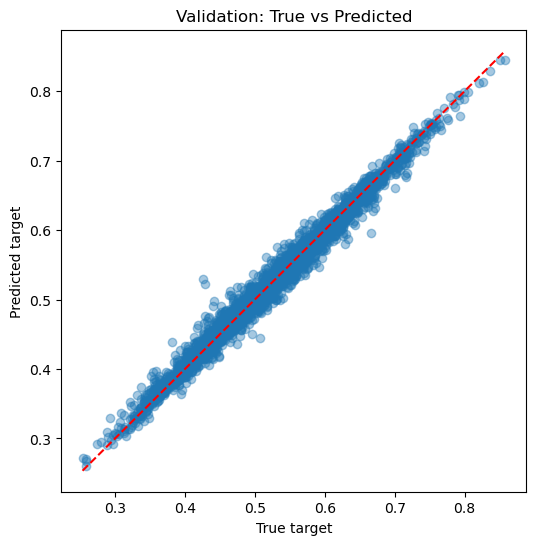

In [130]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, val_pred, alpha=0.4)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--')
plt.xlabel("True target")
plt.ylabel("Predicted target")
plt.title("Validation: True vs Predicted")
plt.show()


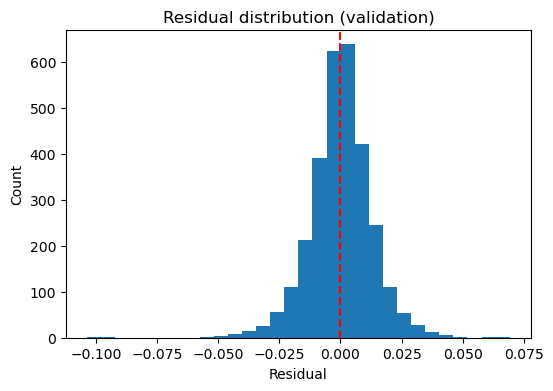

In [131]:
residuals = y_val - val_pred

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual distribution (validation)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()


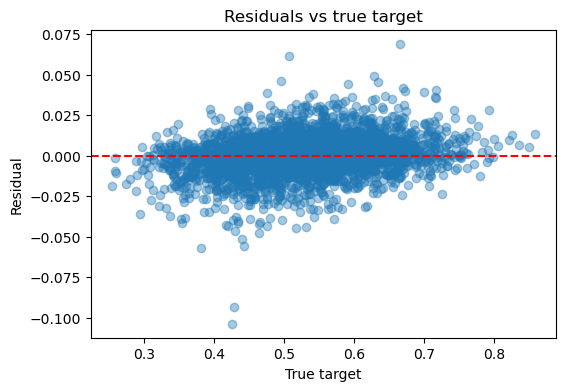

In [132]:
plt.figure(figsize=(6,4))
plt.scatter(y_val, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True target")
plt.ylabel("Residual")
plt.title("Residuals vs true target")
plt.show()

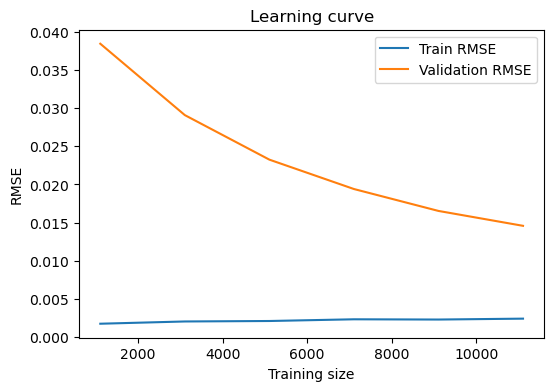

In [133]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_enc,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 6)
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse   = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_rmse, label="Train RMSE")
plt.plot(train_sizes, val_rmse, label="Validation RMSE")
plt.xlabel("Training size")
plt.ylabel("RMSE")
plt.title("Learning curve")
plt.legend()
plt.show()


#### Save the model and encoder

In [134]:
import joblib

joblib.dump(preprocess, "encoder.pkl")
joblib.dump(final_model, "models/workout_model.pkl")

['models/workout_model.pkl']

### Create testing data

In [135]:
# Exercise-related features
exercise_df = df[
    ['Name of Exercise', 'Workout_Type', 'Target Muscle Group',
     'Body Part', 'Type of Muscle', 'Difficulty Level', 'Sets', 'Reps', 'Calories_Burned', 'Workout', 'Benefit']
].reset_index(drop=True)

# Repeat user row to match number of exercises (INLINE, no extra variable)
workout_predict = pd.concat(
    [pd.concat([user] * len(exercise_df), ignore_index=True), exercise_df],
    axis=1
)

workout_predict.head(3)

,Age,Gender,Weight (kg),Height (m),BMI,Workout_Frequency (days/week),Daily meals frequency,diet_type,Experience_Level,Goal,WeightChange (kg),GoalDays,BMR,PAL,TDEE,CalorieChange,CaloriesToBurnTraining,CaloriesReducedFromFood,CaloriesPerDay,TotalWorkouts,CaloriesPerWorkout,cluster_id,Name of Exercise,Workout_Type,Target Muscle Group,Body Part,Type of Muscle,Difficulty Level,Sets,Reps,Calories_Burned,Workout,Benefit
0,22,Male,88.0,1.8,27.160494,2,2,Keto,2,Maintain,2.0,20,1900.0,1.55,2945.0,15400.0,7700.0,7700.0,2945.0,5.714286,1347.5,0,Decline Push-ups,Strength,"Shoulders, Triceps",Legs,Lats,3,5,21,1080.90,Dumbbell flyes,Improves shoulder health and posture
1,22,Male,88.0,1.8,27.160494,2,2,Keto,2,Maintain,2.0,20,1900.0,1.55,2945.0,15400.0,7700.0,7700.0,2945.0,5.714286,1347.5,0,Bear Crawls,HIIT,"Back, Core, Shoulders",Chest,Lats,2,4,16,1809.91,Lateral raises,Strengthens lower abs
2,22,Male,88.0,1.8,27.160494,2,2,Keto,2,Maintain,2.0,20,1900.0,1.55,2945.0,15400.0,7700.0,7700.0,2945.0,5.714286,1347.5,0,Dips,Cardio,"Quadriceps, Glutes",Arms,Grip Strength,2,5,22,802.26,Standing calf raises,Builds chest strength


In [137]:
import joblib

preprocess = joblib.load("encoder.pkl")
final_model = joblib.load("models/workout_model.pkl")

workout_predict_enc = preprocess.transform(workout_predict)
predictions = final_model.predict(workout_predict_enc)

In [138]:
# Add predictions as a new column
workout_predict = workout_predict.copy()
workout_predict["workout_score"] = predictions


workout_predict.head(3)

,Age,Gender,Weight (kg),Height (m),BMI,Workout_Frequency (days/week),Daily meals frequency,diet_type,Experience_Level,Goal,WeightChange (kg),GoalDays,BMR,PAL,TDEE,CalorieChange,CaloriesToBurnTraining,CaloriesReducedFromFood,CaloriesPerDay,TotalWorkouts,CaloriesPerWorkout,cluster_id,Name of Exercise,Workout_Type,Target Muscle Group,Body Part,Type of Muscle,Difficulty Level,Sets,Reps,Calories_Burned,Workout,Benefit,workout_score
0,22,Male,88.0,1.8,27.160494,2,2,Keto,2,Maintain,2.0,20,1900.0,1.55,2945.0,15400.0,7700.0,7700.0,2945.0,5.714286,1347.5,0,Decline Push-ups,Strength,"Shoulders, Triceps",Legs,Lats,3,5,21,1080.90,Dumbbell flyes,Improves shoulder health and posture,0.508331
1,22,Male,88.0,1.8,27.160494,2,2,Keto,2,Maintain,2.0,20,1900.0,1.55,2945.0,15400.0,7700.0,7700.0,2945.0,5.714286,1347.5,0,Bear Crawls,HIIT,"Back, Core, Shoulders",Chest,Lats,2,4,16,1809.91,Lateral raises,Strengthens lower abs,0.554936
2,22,Male,88.0,1.8,27.160494,2,2,Keto,2,Maintain,2.0,20,1900.0,1.55,2945.0,15400.0,7700.0,7700.0,2945.0,5.714286,1347.5,0,Dips,Cardio,"Quadriceps, Glutes",Arms,Grip Strength,2,5,22,802.26,Standing calf raises,Builds chest strength,0.513507


#### Top 100 most suitable exercises based on user profile and goal & Recommendation system

Why this is “classical recommender way”

This matches standard recommender architecture:

1) Candidate generation

Top-100 by predicted relevance (workout_score)

2) Content embedding

TF-IDF vectors from exercise metadata

3) Similarity-based grouping

Cosine similarity to “day prototypes” (a standard content-based trick)

4) Reranking for diversity

MMR is a classic diversification algorithm used in recommender systems.

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ----------------------------
# 1) Candidate generation: Top N
# ----------------------------
TOP_N = 100
candidates = (
    workout_predict
    .sort_values("workout_score", ascending=False)
    .head(TOP_N)
    .reset_index(drop=True)
    .copy()
)

# ----------------------------
# 2) Build text for vectorization (classic content-based)
# ----------------------------
TEXT_COLS = ["Target Muscle Group", "Body Part", "Type of Muscle", "Workout_Type", "Difficulty Level", "Name of Exercise"]

def make_text_profile(df: pd.DataFrame, cols=TEXT_COLS) -> pd.Series:
    tmp = df[cols].copy()
    for c in cols:
        tmp[c] = (tmp[c].astype(str).fillna("")
                  .str.lower()
                  .str.replace(r"\s+", " ", regex=True)
                  .str.strip())
    return tmp.apply(lambda r: " ".join([v for v in r.values if v and v != "nan"]), axis=1)

exercise_text = make_text_profile(candidates)

# TF-IDF vectors for exercises
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)
X_ex = vectorizer.fit_transform(exercise_text)

# ----------------------------
# 3) Create "day prototypes" as text -> vector (classic trick)
# ----------------------------
day_prototypes = {
    "Legs": "legs lower body quads quadriceps hamstrings glutes calves posterior",
    "Push": "chest shoulders triceps upper chest pressing push",
    "Pull": "back lats upper back biceps rows pull",
    "Core": "abs core obliques plank dead bug flutter kicks",
}

proto_text = list(day_prototypes.values())
X_proto = vectorizer.transform(proto_text)  # same vector space

# similarity of each exercise to each day prototype
S_day = cosine_similarity(X_ex, X_proto)   # shape: (n_exercises, 4)

day_names = list(day_prototypes.keys())
candidates["day_label"] = [day_names[i] for i in np.argmax(S_day, axis=1)]
candidates["day_sim"] = np.max(S_day, axis=1)  # confidence (how strongly it matches)

# ----------------------------
# 4) MMR reranking: relevant + diverse inside each day
# ----------------------------
def mmr_select(df_day: pd.DataFrame,
               X_day_vecs,
               k: int = 6,
               alpha: float = 0.7):
    """
    Classic MMR:
      score(item) = alpha * relevance(item) - (1-alpha) * max_sim(item, selected)
    where relevance = workout_score (you can also include day_sim if you want).
    """
    if len(df_day) == 0:
        return df_day

    # normalize relevance to 0..1 for stable mixing
    rel = df_day["workout_score"].to_numpy()
    rel = (rel - rel.min()) / (rel.max() - rel.min() + 1e-9)

    selected_idx = []
    remaining = list(range(len(df_day)))

    # Precompute cosine sims within the day candidate set
    sims = cosine_similarity(X_day_vecs, X_day_vecs)

    while remaining and len(selected_idx) < min(k, len(df_day)):
        if not selected_idx:
            # pick highest relevance first
            best = remaining[int(np.argmax(rel[remaining]))]
        else:
            mmr_scores = []
            for i in remaining:
                max_sim_to_selected = np.max(sims[i, selected_idx])
                mmr = alpha * rel[i] - (1 - alpha) * max_sim_to_selected
                mmr_scores.append(mmr)
            best = remaining[int(np.argmax(mmr_scores))]

        selected_idx.append(best)
        remaining.remove(best)

    return df_day.iloc[selected_idx].copy()

# ----------------------------
# 5) Build a daily plan: each day different, each internally balanced
# ----------------------------
EXERCISES_PER_DAY = 6
alpha = 0.75  # higher => more relevance; lower => more diversity

plan = {}
for day in day_names:
    df_day = candidates[candidates["day_label"] == day].copy()
    if len(df_day) == 0:
        plan[day] = df_day
        continue

    # get vectors corresponding to rows in df_day (same indices as candidates)
    idx = df_day.index.to_numpy()
    X_day = X_ex[idx]

    # MMR selection inside that day
    plan[day] = mmr_select(df_day, X_day, k=EXERCISES_PER_DAY, alpha=alpha)

# ----------------------------
# 6) Display / output
# ----------------------------
cols_show = ["Name of Exercise", "Workout", "Benefit", "Target Muscle Group", "Body Part", "Type of Muscle",
             "Difficulty Level", "Sets", "Reps", "Calories_Burned",
             "workout_score", "day_label", "day_sim"]

for day in day_names:
    print(f"\n===== {day} Day =====")
    display(plan[day][cols_show].reset_index(drop=True))



===== Legs Day =====


,Name of Exercise,Workout,Benefit,Target Muscle Group,Body Part,Type of Muscle,Difficulty Level,Sets,Reps,Calories_Burned,workout_score,day_label,day_sim
0,Dragon Flags,Barbell squats,Activates and strengthens glutes,"Glutes, Hamstrings",Legs,Posterior,1,4,21,2829.22,0.750363,Legs,0.194346
1,Wall Angels,Hanging leg raises,Activates and strengthens glutes,Shoulders,Arms,Lower,1,5,20,2819.27,0.749676,Legs,0.048626
2,Turkish Get-ups,Romanian deadlifts,Targets upper chest,"Quadriceps, Calves, Glutes",Arms,Upper,1,5,25,2704.78,0.749501,Legs,0.158213
3,Renegade Rows,Incline dumbbell press,Improves core stability and balance,"Glutes, Hamstrings, Core",Legs,Wrist Flexors,1,5,21,2575.98,0.749342,Legs,0.122384
4,Leg Raises,Triceps dips,Improves lower back strength,"Glutes, Hamstrings",Forearms,Posterior,1,5,25,2741.38,0.748971,Legs,0.141408
5,Step-ups,Incline dumbbell press,Strengthens lower body,Shoulders,Legs,Posterior,1,5,23,2757.78,0.749195,Legs,0.121535



===== Push Day =====


,Name of Exercise,Workout,Benefit,Target Muscle Group,Body Part,Type of Muscle,Difficulty Level,Sets,Reps,Calories_Burned,workout_score,day_label,day_sim
0,Squats,Leg press,Improves core stability and upper body strength,"Upper Chest, Triceps",Legs,Wrist Extensors,1,5,21,2688.40,0.754797,Push,0.281113
1,Incline Push-ups,Triceps pushdowns,Targets abdominal muscles,"Quadriceps, Glutes",Shoulders,Wrist Flexors,1,5,24,2702.70,0.751373,Push,0.098005
2,Glute Bridges,Hanging leg raises,Improves balance and coordination,"Chest, Triceps, Shoulders",Forearms,Lower,1,5,25,2714.91,0.750699,Push,0.130363
3,Superman,Military press,Improves core stability,"Upper Chest, Triceps",Chest,Grip Strength,1,5,25,2749.82,0.747975,Push,0.339393
4,Decline Push-ups,Barbell hip thrusts,Targets lower chest,Full Core,Chest,Wrist Flexors,1,5,25,2674.10,0.748221,Push,0.135404
5,Wall Angels,Decline cable crossovers,Enhances full-body coordination and stability,"Quadriceps, Glutes",Chest,Triceps,1,5,24,2283.26,0.746775,Push,0.112973



===== Pull Day =====


,Name of Exercise,Workout,Benefit,Target Muscle Group,Body Part,Type of Muscle,Difficulty Level,Sets,Reps,Calories_Burned,workout_score,day_label,day_sim
0,Dead Bugs,Chest flyes,Improves core stability,"Shoulders, Triceps",Back,Lats,1,5,24,2817.10,0.756521,Pull,0.222112
1,Inverted Rows,Incline cable crossovers,Improves core rotation strength,Shoulders,Legs,Upper,1,4,21,2833.58,0.752926,Pull,0.128851
2,Burpees,Russian twists,Targets upper chest,"Rear Deltoids, Upper Back",Legs,Posterior,1,5,20,2833.58,0.752668,Pull,0.154881
3,Deadlifts,Decline dumbbell flyes,Builds calf muscles,Core,Back,Lateral,1,5,21,2678.21,0.751505,Pull,0.062219
4,Pull-ups,Bird dog,Improves posture and strengthens upper back,"Shoulders, Upper Back",Abs,Lats,1,5,25,2714.91,0.750870,Pull,0.330600
5,Mountain Climbers,Bicep Curls,Targets abdominal muscles,"Rear Deltoids, Upper Back",Chest,Wrist Flexors,1,5,21,2590.29,0.750940,Pull,0.134765



===== Core Day =====


,Name of Exercise,Workout,Benefit,Target Muscle Group,Body Part,Type of Muscle,Difficulty Level,Sets,Reps,Calories_Burned,workout_score,day_label,day_sim
0,Flutter Kicks,Close-grip bench press,Improves coordination and cardiovascular health,"Chest, Triceps, Shoulders",Arms,Middle,1,5,23,2821.43,0.755434,Core,0.377134
1,Dead Bugs,Plank,Improves posture and strengthens upper back,"Legs, Shoulders, Core",Back,Posterior,1,5,23,2804.96,0.751177,Core,0.137783
2,Renegade Rows,Military press,Improves core stability and upper body strength,"Obliques, Core",Chest,Quads,1,5,25,2727.10,0.749524,Core,0.106954
3,Bicycle Crunches,Lateral raises,Strengthens triceps and chest,"Core, Obliques",Arms,Upper,1,5,24,2647.54,0.748741,Core,0.203199
4,Bulgarian Split Squats,Pull-ups,Improves hip power and cardiovascular fitness,"Legs, Shoulders, Core",Abs,Grip Strength,1,5,21,2132.68,0.743527,Core,0.061062
5,Tricep Dips,Barbell curls,Strengthens back and improves posture,"Back, Core, Shoulders",Abs,Middle,1,5,25,2008.74,0.741662,Core,0.072272


Exception ignored in: <function ResourceTracker.__del__ at 0x10701dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106f55bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107191bc0>
Traceback (most recent call last